# Source Code of Logistic Regression For Classification

## 1. Load Basic Library

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

## 2. Load Data

### 2.1 Data Preview

In [16]:
# data/ex2data1.txt
path = 'data/ex2data2.txt'

# used same as CSV file, using ',' as the deliter
data = pd.read_csv(path, header=None) 

# setting cols name for df
data.columns = ['Exam1', 'Exam2', 'Admitted']

print(data.head())
# print(data.shape)

      Exam1    Exam2  Admitted
0  0.051267  0.69956         1
1 -0.092742  0.68494         1
2 -0.213710  0.69225         1
3 -0.375000  0.50219         1
4 -0.513250  0.46564         1


### 2.2 More Detail of Data

In [17]:
print(f'Shape: {data.shape}\n')
print(f'Data Type: {type(data)}')
print(data.describe(), '\n')
print(data.info())
# print(f'Target Columns: {set(data[])}')

Shape: (118, 3)

Data Type: <class 'pandas.core.frame.DataFrame'>
            Exam1       Exam2    Admitted
count  118.000000  118.000000  118.000000
mean     0.054779    0.183102    0.491525
std      0.496654    0.519743    0.502060
min     -0.830070   -0.769740    0.000000
25%     -0.372120   -0.254385    0.000000
50%     -0.006336    0.213455    0.000000
75%      0.478970    0.646563    1.000000
max      1.070900    1.108900    1.000000 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Exam1     118 non-null    float64
 1   Exam2     118 non-null    float64
 2   Admitted  118 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 2.9 KB
None


for the info mentioned above, all the data columns **has no NULL value**, and its coresponding datatype.

### 2.3 Visualzation

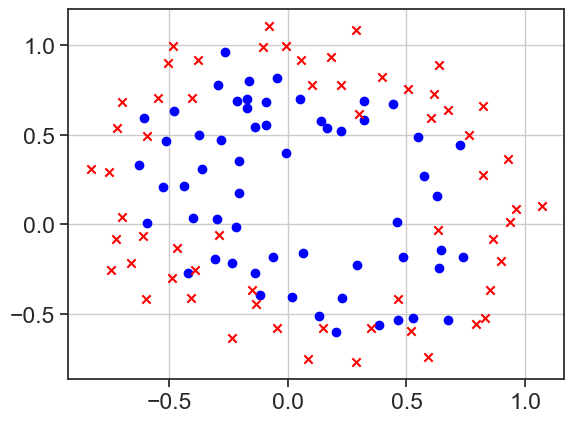

In [18]:
plt.plot(figsize=(8, 6))

plt.scatter(
    data[data['Admitted'] == 1]['Exam1'],
    data[data['Admitted'] == 1]['Exam2'],
    color = 'blue', marker = 'o', label = 'Accepted'
)

plt.scatter(
    data[data['Admitted'] == 0]['Exam1'],
    data[data['Admitted'] == 0]['Exam2'],
    color = 'red', marker = 'x', label = 'Rejected'
)

plt.grid(True)
plt.show()

### 2.4 Feature Engeering

About Feature Engeering

#### `1) Feature Selection:` 

an artical about Feature Selection：[Click: Feature Selection URL](https://neptune.ai/blog/feature-selection-methods)

only choose the features which are **related to task analysis**. (like Titanic Analysis, I choose to delete the column of 'host_position', 'destination', cuz these features **do nothing with task analysis**, it has nothing to do with the ratio of suffering from death or not)

- (1) Based on personal knowledge

- (2) Based on **Correlation Analysis** (how close relation is between each single feature & target value)

- (3) Based on **Feature Importance**: most of them use RandomForest to detect the feature importance
    
- (4) Based on **The ratio of Missing Value**: but I dont think it's a good way to do so. Cuz some of importance features may lack of record because of some special reasons (e.g: in Titanic, the data: 'boat' column is very important, since it can directly influence the rate of survial for passenger in the sinks.)

<!-- <img style="float: center;" src="images/feature_selection_methods.png"> -->

**```-- Feature Selection in Machine Learning```**
<div style="text-align: center;">
  <img src="images/feature_selection_methods.png" alt="特征选择方法" style="width: 500px; height: 300px;">
</div>


```python
# based on self-knowledge to directly delete
# it can only detect some obvious 'useless' features
# it's a rude way !
# drop setting the dimension, (axis = 1)
df = df.drop(['host_position', 'destination'], axis = 1)

#################################################################
# Correlation Analysis
correlation = df.corr()['Survival'].abs() # choose the target column
# delete the columns whose correlation is smaller than 1
cols_to_drop = correlation[correlation < 0.1].index

if 'Survive' in cols_to_drop:
    cols_to_drop = cols_to_drop.drop('Survived')

# drop needs to set the deleted dimension
df = df.drop(cols_to_drop, axis = 1)
#################################################################
# Feature Importance (copy data based to process model)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# not the real trainset / testset
X = df.drop(['Survival'], axis = 1)
y = df['Survival']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# similar with the process of trainning model, but it's not!
# this is just make detection for which feature is more important
# not a real model for task, it's just for feature selection
# just like train a model to choose which features are important?
feature_selection_model = RandomForestClassifier(random_state=42)
feature_selection_model.fit(X_train, y_train)

feature_importance = pd.Series(model.feature_importances_, index = X.columns)
# use index to locate certain conditions
cols_to_drop = feature_importance[feature_importance < 0.01].index

df = df.drop(cols_to_drop, axis = 1)
#################################################################
# now the df is going through 'feature_selection' / 'new_feature_generation' / 'correlation analysis' / 'feature_importance'
df
```


#### `2) New Feature Gernerated:`
choose original **suitable** columns / **new combined** columns
- "New data"
    > e.g: Original Raw data only has 'Date' as feature
    - (1) new1: we can extract 'season', like 'Spring', 'Summer'... to have a better analysis on seasonal selling activities.
        
    - (2) new2: we can also extract 'IS weekend' / 'NOT weekend'... to find whether it's better for sellings on weekends.

    - (3) **Feature Mapping**: like using some dimension improve methos to combine and create as the new column

<!-- images/Feature mapping using multi-variable polynomial.png -->

<div style="text-align: center;">
  <img src="images/tmop_a_554896_o_m0038.png" alt="feature_mapping" style="width: 450px; height:200px;">
</div>

```python
def feature_mapping(x, y, power):
    """Return mapped features as ndarray or dataframe."""
    ele_list = list()
    col_index_list = list()

    for i in range(0, power+1):
        for j in range(0, power+1):
            if (i + j) <= power:
                ele_list.append((x**i) * (y**j))        
                col_index_list.append(f'f{i}{j}')
                
    # build a col vector for it
    # turn into a col vector
    row_vector = pd.DataFrame((np.array(ele_list).T), columns=col_index_list)
    
    return row_vector
```

#### `3) NULL Value Filling:` 
it may has different ratio of NULL value inside each single feature. We use a tool to detect:

```python
# get more detailed information about the columns
print(data.info())
```

```raw
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Exam1     118 non-null    float64
 1   Exam2     118 non-null    float64
 2   Admitted  118 non-null    int64  
```

#### `4) Data Scaling`
choose which to scale? (for features / )
choose what methods to scale?

#### `5) Encoding`
- One Hot-Encoding
- Target Encoding
- Binary Encoding

#### Example: Data Feature Mapping Process

In [19]:
def feature_mapping(x, y, power):
    """Return mapped features as ndarray or dataframe."""
    ele_list = list()
    col_index_list = list()

    for i in range(0, power+1):
        for j in range(0, power+1):
            if (i + j) <= power:
                # create new columns
                ele_list.append((x**i) * (y**j))        
                col_index_list.append(f'f{i}{j}')
                
    # build a col vector for it
    # turn into a col vector
    row_vector = pd.DataFrame((np.array(ele_list).T), columns=col_index_list)
    
    return row_vector

In [20]:
#complete the code below
x1 = np.array(data['Exam1'])
x2 = np.array(data['Exam2'])

print('Raw Input Data Shape:')
print(x1.shape)
print(x2.shape)

Raw Input Data Shape:
(118,)
(118,)


In [21]:
temp_data = feature_mapping(x1, x2, power=6)
print(f'After Feature Mapping Shape: {temp_data.shape}')
temp_data.head()

After Feature Mapping Shape: (118, 28)


,f00,f01,f02,f03,f04,f05,f06,f10,f11,f12,...,f30,f31,f32,f33,f40,f41,f42,f50,f51,f60
0,1.0,0.69956,0.489384,0.342354,0.239497,0.167542,0.117206,0.051267,0.035864,0.025089,...,0.000135,0.000094,0.000066,0.000046,0.000007,0.000005,0.000003,3.541519e-07,2.477505e-07,1.815630e-08
1,1.0,0.68494,0.469143,0.321335,0.220095,0.150752,0.103256,-0.092742,-0.063523,-0.043509,...,-0.000798,-0.000546,-0.000374,-0.000256,0.000074,0.000051,0.000035,-6.860919e-06,-4.699318e-06,6.362953e-07
2,1.0,0.69225,0.479210,0.331733,0.229642,0.158970,0.110047,-0.213710,-0.147941,-0.102412,...,-0.009761,-0.006757,-0.004677,-0.003238,0.002086,0.001444,0.001000,-4.457837e-04,-3.085938e-04,9.526844e-05
3,1.0,0.50219,0.252195,0.126650,0.063602,0.031940,0.016040,-0.375000,-0.188321,-0.094573,...,-0.052734,-0.026483,-0.013299,-0.006679,0.019775,0.009931,0.004987,-7.415771e-03,-3.724126e-03,2.780914e-03
4,1.0,0.46564,0.216821,0.100960,0.047011,0.021890,0.010193,-0.513250,-0.238990,-0.111283,...,-0.135203,-0.062956,-0.029315,-0.013650,0.069393,0.032312,0.015046,-3.561597e-02,-1.658422e-02,1.827990e-02


## 3. Model Part


### 3.1 Data Input & Weights Initialization

In [22]:
#complete the code below
theta = np.zeros(shape=(28, 1), dtype='float64')
print(f'theta.shape: {theta.shape}')

x1 = np.array(data['Exam1'])
x2 = np.array(data['Exam2'])


X = feature_mapping(x1, x2, power=6)
print(f'X.shape: {X.shape}')

y = (data['Admitted'].values).reshape(-1, 1)
# print(y.shape)
print(f"y.shape: {y.shape}")
# print(y)

theta.shape: (28, 1)
X.shape: (118, 28)
y.shape: (118, 1)


### 3.2 Cost Function

`Cost Function Formula`
$$J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]}+\frac{\lambda }{2m}\sum\limits_{j=1}^{n}{\theta _{j}^{2}}$$

Note that you should not regularize the parameter $\theta_0$

In [23]:
### 3.2 Cost Function
#complete the code below
#complete the code for calculating the regularized cost here
#complete the code below
#code here to implement the above cost function

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def cost(theta, X, y):
    ''' cost function for you to minimize'''
    m = len(X)
    
    pred = sigmoid(np.dot(X, theta))
    
    # to avoid the init input to have log(0)
    epsilon = 1e-15
    pred = np.clip(pred, epsilon, 1-epsilon)
    
    # log(sigmoid( pred ))
    cost = (-1 / m ) * np.sum(
        (y * np.log(pred)) + \
        ((1-y) * np.log(1- pred))
    )
    
    return cost

def regularized_cost(theta, X, y, l=1):

    m = len(X)
    
    #     '''you don't penalize theta_0'''
    theta_j1_to_n = theta[1:]
    
    # your code here
    regularized_term = (l / 2*m) * np.sum(theta_j1_to_n ** 2)
    
    # return the whole cost function formula
    return cost(theta, X, y) + regularized_term

In [24]:
regularized_cost(theta, X, y, l=1)

0.6931471805599454

### 3.3 Regularized Gradient

Note that you should not regularize the parameter $\theta_0$：
\begin{align}
  & Repeat\text{ }until\text{ }convergence\text{ }\!\!\{\!\!\text{ } \\ 
 & \text{     }{{\theta }_{0}}:={{\theta }_{0}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{_{0}}^{(i)}} \\ 
 & \text{     }{{\theta }_{j}}:={{\theta }_{j}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{j}^{(i)}}+\frac{\lambda }{m}{{\theta }_{j}} \\ 
 & \text{          }\!\!\}\!\!\text{ } \\ 
 & Repeat \\ 
\end{align}

Calculate the gradient:


In [25]:
#complete the code below
#complete the code for calculating the regularized gradient here
def regularized_gradient(theta, X, y, reg_lambda=1):
#     '''still, leave theta_0 alone'''
    m = len(X)
    
    # make X into nd array
    X = np.array(X)

    # print(f'X.T shape: {X.T.shape}')
    # print(f'error shape: {error.shape}')
    # theta[0] -= (1/m) * np.sum(X.T, error)
    # theta[1:] -= (1/m) * np.sum(X.T, error) + (reg_lambda/m) * theta[1:]
    
    pred = sigmoid(np.dot(X, theta))
    epsilon = 1e-15
    pred = np.clip(pred, epsilon, 1-epsilon)
    
    print(f'X.shape: {X.shape}')
    print(f'pred.shape: {pred.shape}')
    print(f'y.shape: {y.shape}')
    
    error = pred - y
    
    # grad_0: (1,)
    # grad_j_to_n: (27, 1)
    
    grad_0 = (1/m) * np.dot(X[:, 0], error)
    grad_0 = grad_0.reshape(-1, 1)
    
    grad_j_to_n = (1/m) * np.dot(X[:, 1:].T, error) + (reg_lambda / m) * theta[1:]
    
    print(f'grad_0: {grad_0.shape}')
    print(f'grad_j_to_n: {grad_j_to_n.shape}')
    
    total_grad = np.vstack([grad_0, grad_j_to_n])
    
    # return the same dimension as the feature columns
    return total_grad

In [26]:
regularized_gradient(theta, X, y)

X.shape: (118, 28)
pred.shape: (118, 1)
y.shape: (118, 1)
grad_0: (1, 1)
grad_j_to_n: (27, 1)


array([[8.47457627e-03],
       [7.77711864e-05],
       [3.76648474e-02],
       [2.34764889e-02],
       [3.93028171e-02],
       [3.10079849e-02],
       [3.87936363e-02],
       [1.87880932e-02],
       [1.15013308e-02],
       [8.19244468e-03],
       [3.09593720e-03],
       [4.47629067e-03],
       [1.37646175e-03],
       [5.03446395e-02],
       [7.32393391e-03],
       [1.28600503e-02],
       [5.83822078e-03],
       [7.26504316e-03],
       [1.83559872e-02],
       [2.23923907e-03],
       [3.38643902e-03],
       [4.08503006e-04],
       [3.93486234e-02],
       [4.32983232e-03],
       [6.31570797e-03],
       [1.99707467e-02],
       [1.09740238e-03],
       [3.10312442e-02]])

### 3.4 Combined As a Whole

/var/folders/nk/1w4w_4vj1q56j6rffdl50r_80000gn/T/ipykernel_2960/4287753975.py:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/Users/suleynan_suir/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 400x300 with 0 Axes>

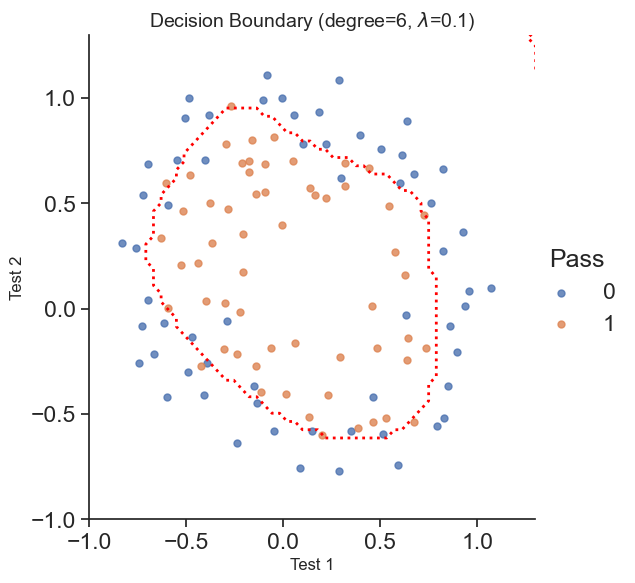

/Users/suleynan_suir/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 400x300 with 0 Axes>

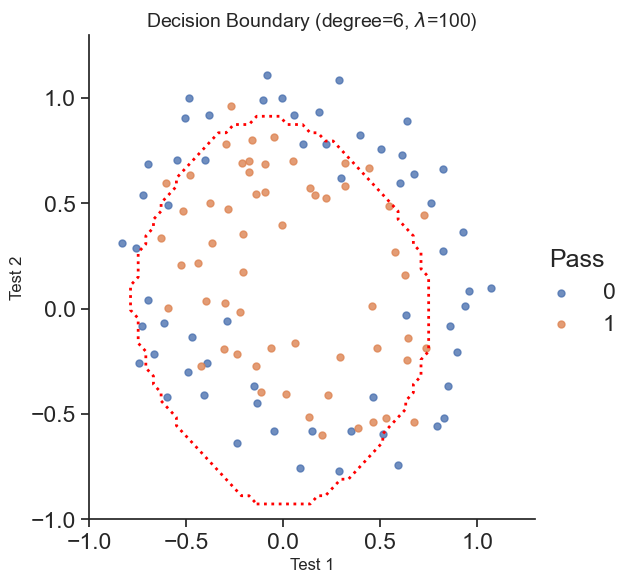

/var/folders/nk/1w4w_4vj1q56j6rffdl50r_80000gn/T/ipykernel_2960/4287753975.py:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/Users/suleynan_suir/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 400x300 with 0 Axes>

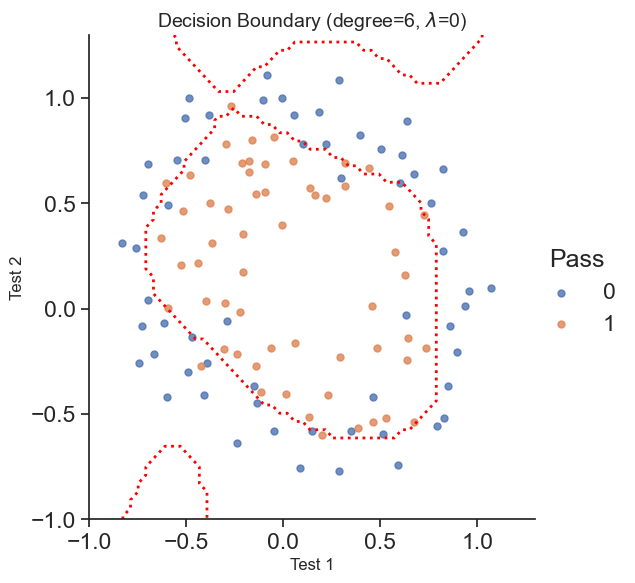

/var/folders/nk/1w4w_4vj1q56j6rffdl50r_80000gn/T/ipykernel_2960/4287753975.py:23: RuntimeWarning: divide by zero encountered in log
  cost = (-y.T @ np.log(h) - (1 - y).T @ np.log(1 - h)) / m
/var/folders/nk/1w4w_4vj1q56j6rffdl50r_80000gn/T/ipykernel_2960/4287753975.py:23: RuntimeWarning: invalid value encountered in matmul
  cost = (-y.T @ np.log(h) - (1 - y).T @ np.log(1 - h)) / m
/var/folders/nk/1w4w_4vj1q56j6rffdl50r_80000gn/T/ipykernel_2960/4287753975.py:23: RuntimeWarning: divide by zero encountered in log
  cost = (-y.T @ np.log(h) - (1 - y).T @ np.log(1 - h)) / m
/var/folders/nk/1w4w_4vj1q56j6rffdl50r_80000gn/T/ipykernel_2960/4287753975.py:23: RuntimeWarning: invalid value encountered in matmul
  cost = (-y.T @ np.log(h) - (1 - y).T @ np.log(1 - h)) / m
/var/folders/nk/1w4w_4vj1q56j6rffdl50r_80000gn/T/ipykernel_2960/4287753975.py:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/Users/suleynan_suir/anaconda3/lib/python3.11/site-packages/seaborn/axisg

<Figure size 400x300 with 0 Axes>

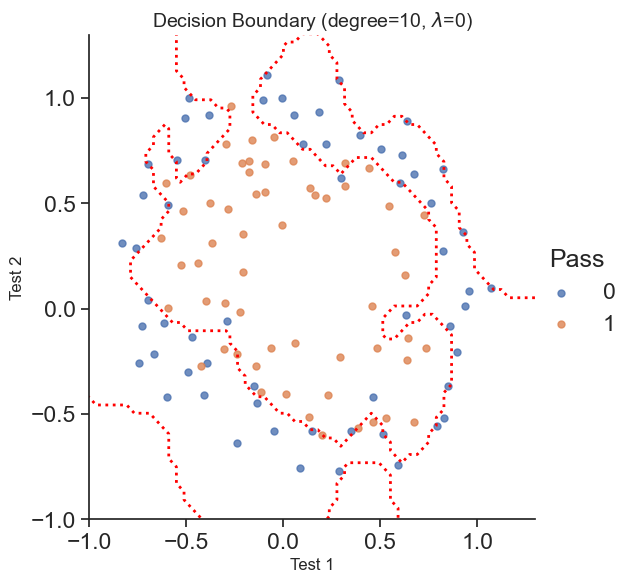

In [27]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import scipy.optimize as opt

# @Overwrite
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# @Overwrite
def feature_mapping(x, y, power):
    features = []
    for i in range(power + 1):
        for j in range(power + 1 - i):
            features.append((x**i) * (y**j))
    return pd.DataFrame(np.array(features).T)

# @Overwrite
def regularized_cost(theta, X, y, l=1):
    m = len(y)
    h = sigmoid(X @ theta)
    cost = (-y.T @ np.log(h) - (1 - y).T @ np.log(1 - h)) / m
    reg = (l / (2 * m)) * np.sum(theta[1:]**2)
    return cost + reg

# @Overwrite
def regularized_gradient(theta, X, y, l=1):
    m = len(y)
    h = sigmoid(X @ theta)
    grad = (X.T @ (h - y)) / m
    grad[1:] += (l / m) * theta[1:]  # Add regularization
    return grad

# @Overwrite
def predict(theta, X, threshold=0.5):
    return (sigmoid(X @ theta) >= threshold).astype(int)

# Decision boundary visualization
def draw_boundary(power, l):
    # Load and prepare data
    data = pd.read_csv('ex2data2.txt', header=None, names=['Test1', 'Test2', 'Pass'])
    x1 = data.Test1.values
    x2 = data.Test2.values
    y = data.Pass.values
    
    # Generate and scale features
    X = feature_mapping(x1, x2, power)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Optimize parameters
    initial_theta = np.zeros(X.shape[1])
    res = opt.minimize(
        fun=regularized_cost,
        x0=initial_theta,
        args=(X, y, l),
        method='BFGS',
        jac=regularized_gradient
    )
    theta = res.x
    
    # prediction grid
    u = np.linspace(np.min(x1) - 1, np.max(x1) + 1, 100)
    v = np.linspace(np.min(x2) - 1, np.max(x2) + 1, 100)
    U, V = np.meshgrid(u, v)
    
    # features lab
    grid_features = []
    for i, j in zip(U.ravel(), V.ravel()):
        grid_features.append(
            feature_mapping(np.array([i]), np.array([j]), power).values.flatten()
        )
    grid_scaled = scaler.transform(grid_features)
    
    # pred
    Z = (sigmoid(grid_scaled @ theta) >= 0.5)
    Z = Z.reshape(U.shape)
    
    # Plot results using seaborn style
    sns.set(context="notebook", style="ticks", font_scale=1.5)
        
    # sns.lmplot(x='Exam1', y='Exam2', hue='Admitted', data=data,
    #        height=6, 
    #        fit_reg=False, 
    #        scatter_kws={"s": 25})
    
    # Create lmplot with the Seaborn style
    plt.figure(figsize=(4, 3))
    sns.lmplot(x='Test1', y='Test2', hue='Pass', data=data, 
               height=6, fit_reg=False, scatter_kws={"s": 25})
    
    # Contour plot for decision boundary
    plt.contour(U, V, Z, levels=[0.5], colors='red', linestyles='dotted', linewidths=2)
    
    # Customize the plot with labels and title
    plt.title(f"Decision Boundary (degree={power}, $\lambda$={l})", fontsize=14)
    plt.xlabel("Test 1", fontsize=12)
    plt.ylabel("Test 2", fontsize=12)
    plt.xlim(-1, 1.3)
    plt.ylim(-1, 1.3)
    # plt.legend(title="Pass Test", title_fontsize=12)
    plt.show()

# Example usage with different lambda values
draw_boundary(power=6, l=0.1)
draw_boundary(power=6, l=100)
draw_boundary(power=6, l=0)
draw_boundary(power=10, l=0)

### Comparision in Graid

`Important Code`
```python

### Feature Map ###
# how to limit the total term's power sum is lower or equal to the pre-setting power
# lower is fine, we just need to set the upper threshold
for i in range(power + 1):
    for j in range(power + 1 - i):
        features.append((x**i) * (y**j))
    
    return pd.DataFrame(np.array(features).T)

### reg term ###
def regularized_cost(theta, X, y, l):
    cost = (-1 / m) * (y.T @ np.log(sigmoid(theta @ X)) + (1-y).T @ np.log(1 - sigmoid(theta @ X)))

    # setting theta[1:] => is to filter the array apart from 'bias' term
    reg = (l / (2*m)) * np.sum(theta[1:] ** 2)

    # total Cost funtion
    return cost + reg

### reg gradient desc ###
# based on the reg_cost
# so the gradient computation also limited by reg term

def reg_grad(theta, X, y, l):
    # ...
    grad = (X.T @ (sigmoid(X @ theta.T) - y)) / m

    # this is just act on the original data's certain part
    # act only on grad's [1: ] part then assign to it
    grad[1:] += (l/m) * theta[1:]

# the condition judgement of array
# (sigmoid(X @ theta) >= threshold) is just judging whether each element inside the array satisfies the condition (if yes, noted as True,otherwise noted as False)
# so, using condition judgement is the same size as original array
(sigmoid(X @ theta) >= threshold).astype
```

---

<class 'numpy.ndarray'>


/var/folders/nk/1w4w_4vj1q56j6rffdl50r_80000gn/T/ipykernel_2960/2001169940.py:10: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/var/folders/nk/1w4w_4vj1q56j6rffdl50r_80000gn/T/ipykernel_2960/2001169940.py:10: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/var/folders/nk/1w4w_4vj1q56j6rffdl50r_80000gn/T/ipykernel_2960/2001169940.py:10: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/var/folders/nk/1w4w_4vj1q56j6rffdl50r_80000gn/T/ipykernel_2960/2001169940.py:10: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/var/folders/nk/1w4w_4vj1q56j6rffdl50r_80000gn/T/ipykernel_2960/2001169940.py:10: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/var/folders/nk/1w4w_4vj1q56j6rffdl50r_80000gn/T/ipykernel_2960/2001169940.py:34: RuntimeWarning: divide by zero encountered in log
  cost = -(y.T @ np.log(h) + (1 - y).T @ np.log(1 - h)) / m
/var/folders/nk/1w4w_4vj1q56

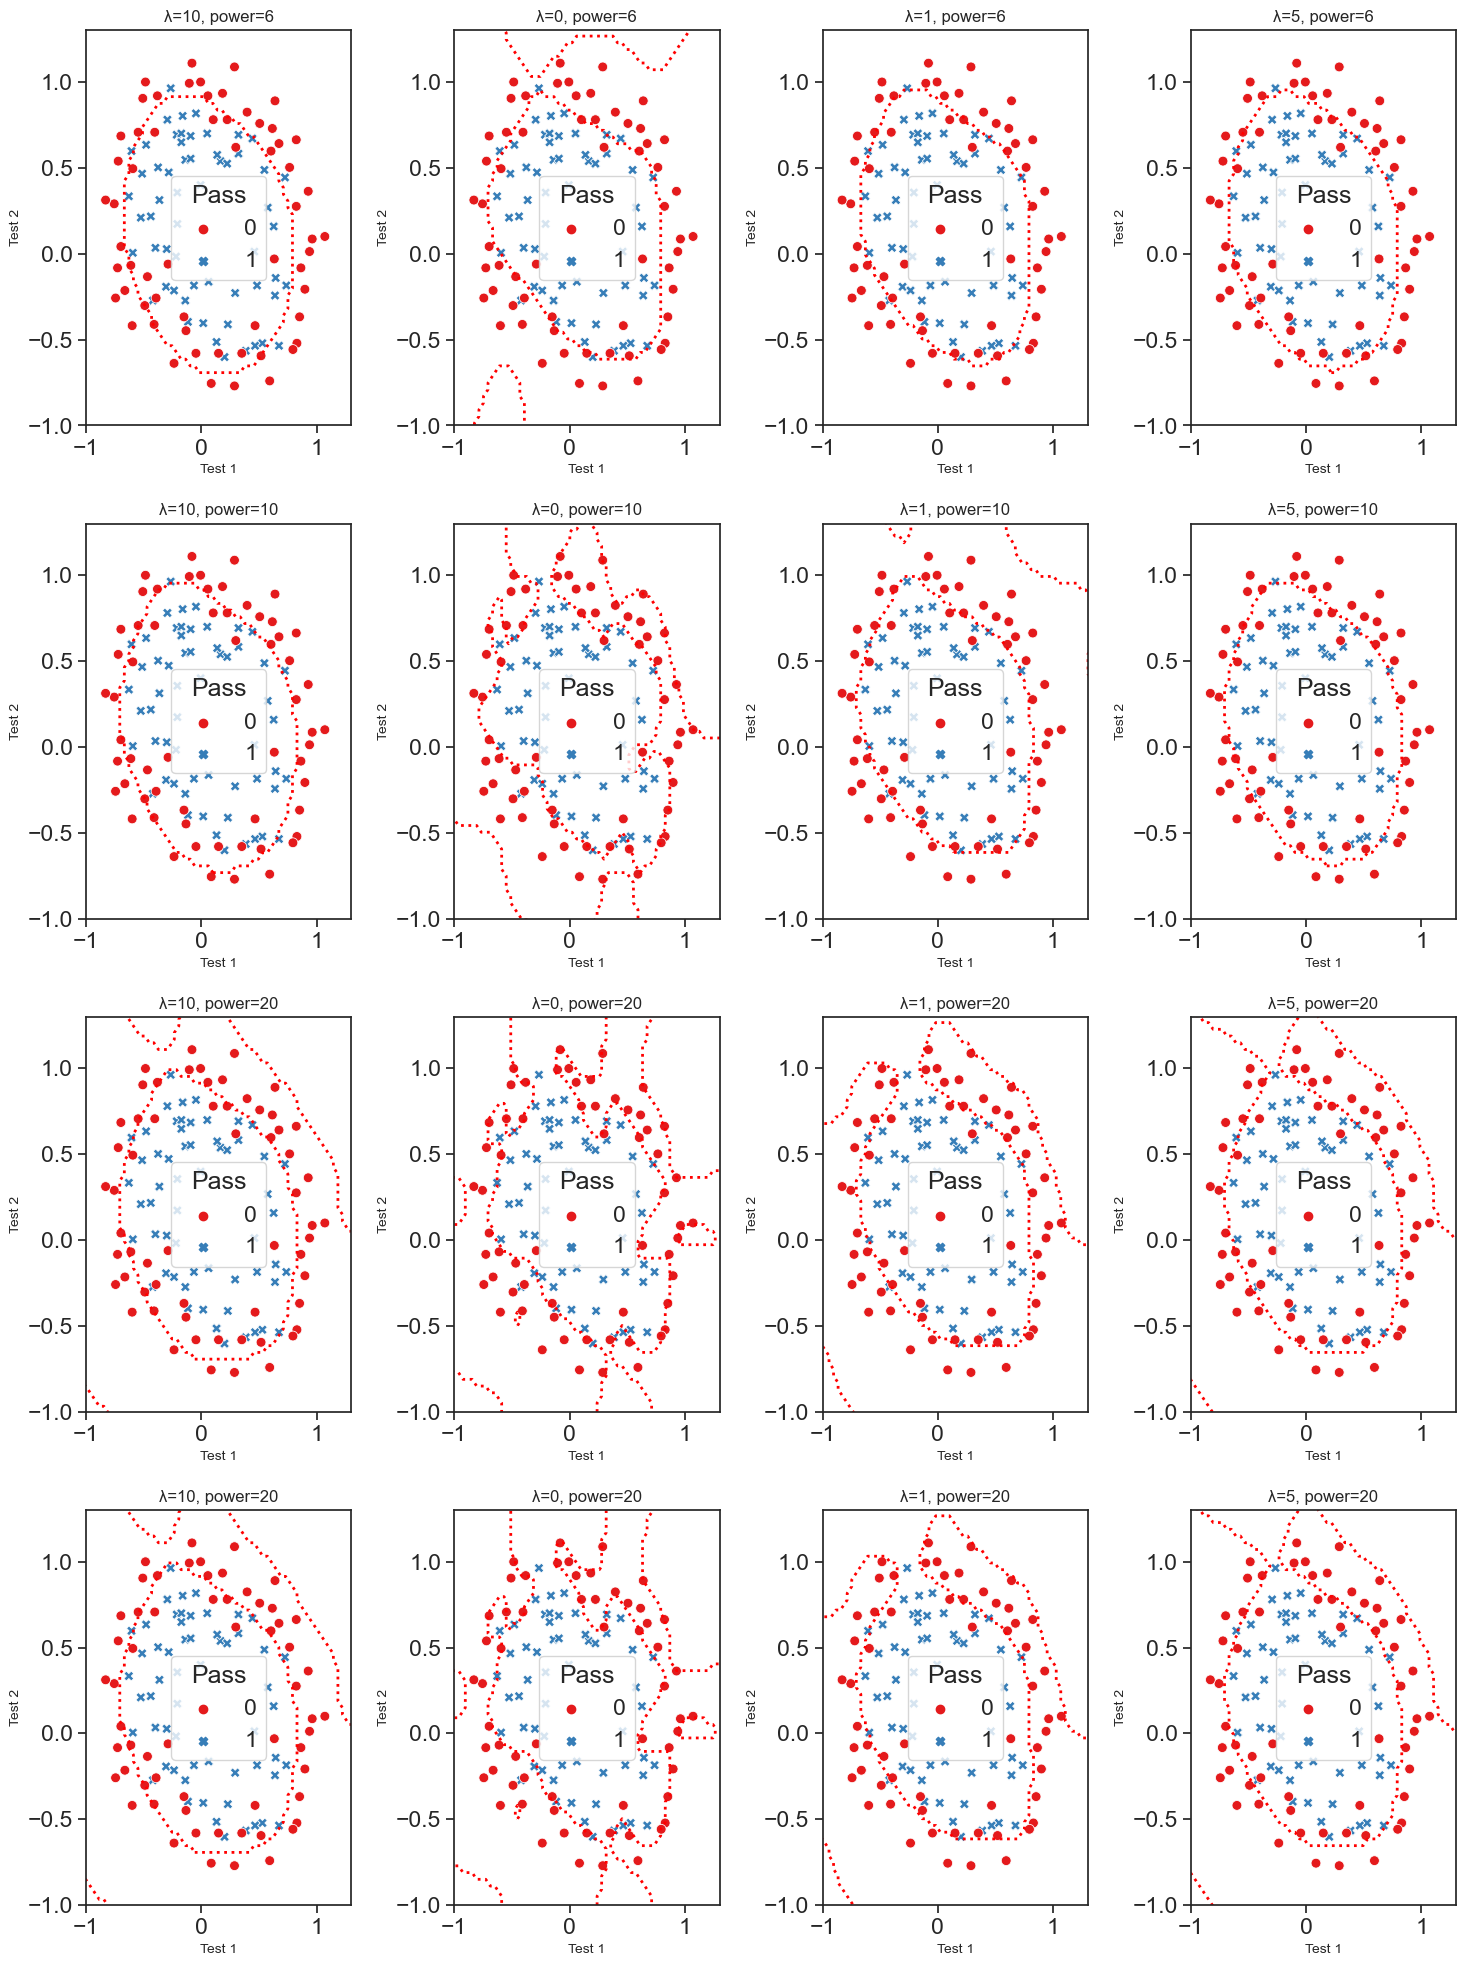

In [31]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# @Overwrite
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# @Overwrite
def feature_mapping(x, y, power):
    features = []
    # a single exp i can reach the pre-setting 'power'
    for i in range(power + 1):
        # limit the other power of j, which makes the sum with i, together **smaller or equal** than 'power'
        for j in range(power + 1 - i):
            # a row
            features.append((x**i) * (y**j))
    
    # turn as a column
    return pd.DataFrame(np.array(features).T)

# @Overwrite
def regularized_cost(theta, X, y, l=1):
    m = len(y)
    # input goes through 'theta' multiply & sigmoid activation function
    h = sigmoid(X @ theta)
    
    # Binary Classification Result ( so it has <y> & <1-y> )
    # the log / sigmoid function is used on each single value,
    # it has nothing to do with the size
    cost = -(y.T @ np.log(h) + (1 - y).T @ np.log(1 - h)) / m
    
    # reg part is limited by lambda
    reg = (l / (2 * m)) * np.sum(theta[1:]**2)
    return cost + reg

# @Overwrite
def regularized_gradient(theta, X, y, l=1):
    m = len(y)
    h = sigmoid(X @ theta)
    grad = (X.T @ (h - y)) / m
    
    # this 'l' term is left by Cost Function
    grad[1:] += (l / m) * theta[1:]  # Add regularization
    return grad

# @Overwrite
def predict(theta, X, threshold=0.5):
    # () >= thresshold, then this array is output as T / F, the same size as original array
    # astype(int), transform the Binary Value into Int type
    return (sigmoid(X @ theta) >= threshold).astype(int)

# Decision boundary visualization with grid arrangement for both lambda and power
def draw_boundary_grid(lambda_values, power_values):
    # Load and prepare data
    data = pd.read_csv('ex2data2.txt', header=None, names=['Test1', 'Test2', 'Pass'])
    x1 = data.Test1.values
    # <class 'numpy.ndarray'>
    print(type(x1))
    x2 = data.Test2.values
    y = data.Pass.values
    
    # Calculate total number of plots (lambda * power combinations)
    n = len(lambda_values) * len(power_values)
    rows = (n + 2) // 4  # Calculate the number of rows needed for the grid layout
    
    # Create subplots
    fig, axes = plt.subplots(rows, 4, figsize=(15, 5 * rows))
    axes = axes.flatten()  # Flatten to make it easier to index
    
    # Loop over lambda and power values and plot decision boundary
    idx = 0
    for power in power_values:
        for l in lambda_values:
            # Generate features and scale
            X = feature_mapping(x1, x2, power)
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            
            # Optimize parameters
            initial_theta = np.zeros(X_scaled.shape[1])
            res = opt.minimize(
                fun=regularized_cost,
                x0=initial_theta,
                args=(X_scaled, y, l),
                method='BFGS',
                jac=regularized_gradient
            )
            theta = res.x
            
            # Prediction grid
            u = np.linspace(np.min(x1) - 1, np.max(x1) + 1, 100)
            v = np.linspace(np.min(x2) - 1, np.max(x2) + 1, 100)
            U, V = np.meshgrid(u, v)
            
            # Features for grid
            grid_features = []
            for i, j in zip(U.ravel(), V.ravel()):
                grid_features.append(
                    feature_mapping(np.array([i]), np.array([j]), power).values.flatten()
                )
            grid_scaled = scaler.transform(grid_features)
            
            # Prediction
            Z = (sigmoid(grid_scaled @ theta) >= 0.5)
            Z = Z.reshape(U.shape)
            
            # Plot each decision boundary in the subplot
            ax = axes[idx]
            sns.set(context="notebook", style="ticks", font_scale=1.5)
            
            # Create scatter plot with Seaborn style
            sns.scatterplot(x=data.Test1, y=data.Test2, hue=data.Pass, style=data.Pass, 
                            palette="Set1", markers=["o", "X"], s=50, ax=ax)
            
            # Contour plot for decision boundary
            ax.contour(U, V, Z, levels=[0.5], colors='red', linestyles='dotted', linewidths=2)
            
            # Customize the plot with labels and title
            ax.set_title(f"λ={l}, power={power}", fontsize=12)
            ax.set_xlabel("Test 1", fontsize=10)
            ax.set_ylabel("Test 2", fontsize=10)
            ax.set_xlim(-1, 1.3)
            ax.set_ylim(-1, 1.3)
            
            # Increment the index for the next subplot
            idx += 1
    
    # Remove unused axes if the number of lambda * power combinations isn't a multiple of 3
    for j in range(idx, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage with different lambda and power values
lambda_values = [10, 0, 1, 5]  # Example lambda values
power_values = [6, 10, 20, 20]      # Example power values

draw_boundary_grid(lambda_values, power_values)
